# Table of Contents

1.  [Introduction](#org413d065)
2.  [Code](#org96b00ef)
    1.  [Importing Libraries](#org3acb348)
    2.  [Flopy model](#orgb3310d2)
    3.  [Zone budget](#org4791276)
3.  [Export to vtk format](#org789ee7c)

<a id="org413d065"></a>
# Introduction
This model is very basic model on a simple grid to show what flopy can do, and be familiar with the functions and classes in flopy. We’ll use the model from the flopy github readme, and make and run the model. It’s mostly to confirm your installation of modf·low and flopy are correct and any code we write for other exercises will be run properly.

<a id="org96b00ef"></a>

# Code


<a id="org3acb348"></a>

## Importing Libraries

First Let's load libraries, flopy is the flopy library and matplotlib is for plotting the plots, flopy also uses this internally for the plots.

In [1]:
import flopy
import matplotlib.pyplot as plt

<a id="orgb3310d2"></a>

## Flopy model

We also need to define the working directories flopy will save the modflow model in that directory with given name. Here we also **give the exe_name which is the modflow executable** to be called for simulation.

In [2]:
ws = './models/01_github_example/'
name = '01_git_ex'
sim = flopy.mf6.MFSimulation(sim_name=name, sim_ws=ws, exe_name='modflow-mf6')

After we have a simulation object, we can add more packages. Here tdis package is for time descretization we’re using the default values as we don’t have timesteps.

I don’t know what ims package does.

gwf is groundwaterflow package.

In [3]:
tdis = flopy.mf6.ModflowTdis(sim)
ims = flopy.mf6.ModflowIms(sim)
gwf = flopy.mf6.ModflowGwf(sim, modelname=name, save_flows=True)

Here we define descretization package which will take number of rows and columns and make a grid internally. We’re using 10x10 grids.

In [4]:
dis = flopy.mf6.ModflowGwfdis(gwf, nrow=10, ncol=10)
ic = flopy.mf6.ModflowGwfic(gwf)
npf = flopy.mf6.ModflowGwfnpf(gwf, save_specific_discharge=True)

Now we can use chd package which is used for constant head conditions, we have assigned two points with heads 1 and zero we we can see the flow from higher head to lower.

In [5]:
chd = flopy.mf6.ModflowGwfchd(gwf, stress_period_data=[[(0, 0, 0), 1.],
                                                       [(0, 9, 9), 0.]])

Now the oc package will be used to give the filenames for where the results will be saved. We can load these files directly and use the data next time if running model everytime is troublesome.

In [6]:
budget_file = name + '.bud'
head_file = name + '.hds'
oc = flopy.mf6.ModflowGwfoc(gwf,
                            budget_filerecord=budget_file,
                            head_filerecord=head_file,
                            saverecord=[('HEAD', 'ALL'), ('BUDGET', 'ALL')])

After we have all the packages we use `write_simulation()` function to write the files for the simulation that will be used my modflow when we use `run_simulation()`.

In [7]:
sim.write_simulation()
sim.run_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package ims_-1...
  writing model 01_git_ex...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package chd_0...
INFORMATION: maxbound in ('gwf6', 'chd', 'dimensions') changed to 2 based on size of stress_period_data
    writing package oc...
FloPy is using the following executable to run the model: /usr/local/bin/modflow-mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.2.2 07/30/2021

  MODFLOW 6 compiled Sep 19 2021 15:10:43 with GFORTRAN compiler (ver. 11.1.0)

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to further analysis and review. 

(True, [])

The output of `run_simulation()` is `True`, hence the model run was successful.

We can extract the values from the model. We can also extract them using the output files we saved using oc package.

In [8]:
head = gwf.output.head().get_data()
bud = gwf.output.budget()

The output files for head and bud are binary files and are quite hard to read (even more so because 3D data are compressed to 1D), so we’re going to use postprocessing tools to get the data we want. Let’s get the specific discharge values so we can use them to plot arrows in the plan to show the direction of flow.



In [9]:
spdis = bud.get_data(text='DATA-SPDIS')[0]
qx, qy, qz = flopy.utils.postprocessing.get_specific_discharge(spdis, gwf)

Now we can use model structure and the output to make plots.

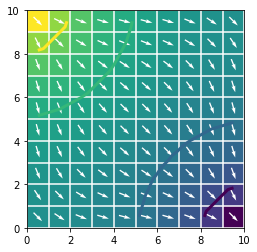

In [10]:
pmv = flopy.plot.PlotMapView(gwf)
pmv.plot_array(head)
pmv.plot_grid(colors='white')
pmv.contour_array(head, levels=[.2, .4, .6, .8], linewidths=3.)
pmv.plot_vector(qx, qy, normalize=True, color="white")
plt.savefig("./images/1_results_plan.png")

If you want to save the figure use this. You can save png or pdf. You can use `plt.show()` to view it.

We got the result which is same as that in the example. So it was a success.

<a id="org4791276"></a>

## Zone budget

We hadn't imported numpy so let's do that.

In [11]:
import numpy as np

We'll make a array with same shape as grid and put some arbitrary cells as different zones. We'll define 3 zones (1, 2 & 3) to cover the whole domain, since we're only using this to verify zonebudget work it's pretty random.

In [12]:
zones = np.ones((10, 10), dtype=int)
zones[(1, 1)] = 2
zones[(2, 2)] = 2
zones[(7, 7)] = 3
zones[(8, 8)] = 3

Make a zonebudget model.

In [13]:
bm = gwf.output.zonebudget(zones)
bm.change_model_name(name)
bm.change_model_ws(ws)

Write input files and run it.

In [14]:
bm.write_input()                # see NOTE
bm.run_model(exe_name='modflow-zbud6')

FloPy is using the following executable to run the model: /usr/local/bin/modflow-zbud6
                              ZONEBUDGET Version 6
                             U.S. GEOLOGICAL SURVEY
                            VERSION 6.2.2 07/30/2021
....

Normal Termination


(True, [])

**NOTE**: The `bm.write_input()` has a bug and doesn't write the grb file and it'll end up being an error. [I brought it to the attention of the developers and they've fixed it](https://github.com/modflowpy/flopy/issues/1395). But it's not yet available to the pip version 3.3.5. If the next version isn't yet released when you're trying out, then you can install the git's latest version with `pip install --upgrade git+https://github.com/modflowpy/flopy.git` in your terminal.

Now we can get the zonebudget for the model.

In [15]:
bm.get_budget()

rec.array([(1., 0, 0, 'DATA_SPDIS_IN', 0.        , 0.        , 0.        ),
           (1., 0, 0, 'CHD_IN', 0.33205402, 0.        , 0.        ),
           (1., 0, 0, 'DATA_SPDIS_OUT', 0.        , 0.        , 0.        ),
           (1., 0, 0, 'CHD_OUT', 0.33204178, 0.        , 0.        ),
           (1., 0, 0, 'FROM_ZONE_0', 0.        , 0.        , 0.        ),
           (1., 0, 0, 'FROM_ZONE_1', 0.        , 0.214903  , 0.21490513),
           (1., 0, 0, 'FROM_ZONE_2', 0.21488982, 0.        , 0.        ),
           (1., 0, 0, 'FROM_ZONE_3', 0.21490489, 0.        , 0.        ),
           (1., 0, 0, 'TO_ZONE_0', 0.        , 0.        , 0.        ),
           (1., 0, 0, 'TO_ZONE_1', 0.        , 0.21488982, 0.21490489),
           (1., 0, 0, 'TO_ZONE_2', 0.214903  , 0.        , 0.        ),
           (1., 0, 0, 'TO_ZONE_3', 0.21490513, 0.        , 0.        )],
          dtype=[('totim', '<f8'), ('time_step', '<i8'), ('stress_period', '<i8'), ('name', 'O'), ('ZONE_1', '<f8'), ('ZONE

<a id="org789ee7c"></a>

# Export to vtk format

We can also export the heads data we obtained from the simulation and then visualize it using external tools like Paraview.

In [16]:
import os
from flopy.export import vtk
vtk.export_heads(sim.get_model(), os.path.join(ws, head_file), ws, smooth=False, kstpkper=[(0,0)], point_scalars=False, nanval=-1e30)

/home/gaurav/.local/lib/python3.10/site-packages/flopy/export/vtk.py:1844: UserWarning: export_heads is deprecated, use Vtk.add_heads()
  warnings.warn("export_heads is deprecated, use Vtk.add_heads()")
/home/gaurav/.local/lib/python3.10/site-packages/flopy/export/vtk.py:1847: UserWarning: nanval is deprecated, setting to np.nan
  warnings.warn("nanval is deprecated, setting to np.nan")


After running the code we get a `.vtk` file in the same directory as the model files, after that we can load it in Paraview, as seen in figure below.

![img](./images/paraview-sc-1.png "Visualization of Heads in Paraview.")